# perkenalan

Nama : Rizqi Golda

Batch : FTDS-018-RMT

Dataset : bigquery-public-data.ml_datasets.census_adult_income

Objective : Menurut laporan dari `statista` di (https://www.statista.com/statistics/203183/percentage-distribution-of-household-income-in-the-us/), ada sebesar `36,1%` penduduk US yang memiliki pendapatan dibawah `$50,000` per tahun. dalam dataset yang digunakan pada kali ini, terdapat faktor apa saja yang menyebabkan masyarakat berpenghasilan dibawah `$50,000`. Project kali ini bertujuan untuk memprediksi dan mengelompokkan pendapatan masyarakat dengan beberapa faktor yang telah disediakan.

# library

memasukkan semua library yang diperlukan selama proses `machine learning`

In [1]:
from google.colab import auth
from google.cloud import bigquery
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from collections import Counter
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
import pickle
import json
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import accuracy_score,classification_report,ConfusionMatrixDisplay,confusion_matrix
from sklearn.svm import SVC, SVR 


auth.authenticate_user()
project_id = "hactiv8-project1"
client = bigquery.Client(project=project_id)

# query sql

query dataset dari `bigquery-public-data.ml_datasets.census_adult_income` dan di ambil data `umur`, `jenis pekerjaan`, `edukasi`, `status perkawinan`, `pekerjaan`, `golongan di keluarga`, `ras`, `jenis kelamin`, `capital_gain`, `capital_loss`, `lama kerja dalam seminggu`, `negara kelahiran`, dan `kelompok pendapatan` tanpa adanya data `jenis pekerjaan` dan `pekerjaan` yang memiliki nilai `?` serta hanya menyajikan data yang `lama kerja dalam seminggu` dibawah `100` jam. jumlah data tersebut dilimit pada `36090` data saja.

In [2]:
data = client.query('''
SELECT 
    age, 
    workclass, 
    education, 
    education_num, 
    marital_status, 
    occupation, 
    relationship, 
    race, 
    sex, 
    capital_gain, 
    capital_loss, 
    hours_per_week, 
    native_country, 
    income_bracket
FROM 
    bigquery-public-data.ml_datasets.census_adult_income
WHERE 
    workclass != ' ?' AND
    occupation != ' ?' AND
    native_country != ' ?' AND
    hours_per_week < 100
LIMIT
    36090
''').to_dataframe()

memastikan tidak ada kolom pada `workclass` dan `occupation` dengan nilai ` ?` dan `hours_per_week` kurang dari `100`.

In [3]:
print('list data apa saja yang ada di kolom `workclass`')
print(data['workclass'].value_counts())
print('\n')
print('\n')
print('list data apa saja yang ada di kolom `occupation`')
print(data['occupation'].value_counts())
print('\n')
print('\n')
print('nilai terbesar pada kolom `hours_per_week`')
print(data['hours_per_week'].max())

list data apa saja yang ada di kolom `workclass`
 Private             22286
 Self-emp-not-inc     2499
 Local-gov            2067
 State-gov            1279
 Self-emp-inc         1074
 Federal-gov           943
 Without-pay            14
Name: workclass, dtype: int64




list data apa saja yang ada di kolom `occupation`
 Prof-specialty       4038
 Craft-repair         4030
 Exec-managerial      3992
 Adm-clerical         3721
 Sales                3584
 Other-service        3212
 Machine-op-inspct    1966
 Transport-moving     1572
 Handlers-cleaners    1350
 Farming-fishing       989
 Tech-support          912
 Protective-serv       644
 Priv-house-serv       143
 Armed-Forces            9
Name: occupation, dtype: int64




nilai terbesar pada kolom `hours_per_week`
99


dari data diatas, nampak tidak terlihat value yang bernilai ` ?` pada kolom `occupation` dan `workclass`. serta nilai tertinggi pada kolom `hours_per_week` sebesar `99`.

melihat 10 data teratas.

In [4]:
data.head(10)

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
0,39,Private,9th,5,Married-civ-spouse,Other-service,Wife,Black,Female,3411,0,34,United-States,<=50K
1,77,Private,9th,5,Married-civ-spouse,Priv-house-serv,Wife,Black,Female,0,0,10,United-States,<=50K
2,38,Private,9th,5,Married-civ-spouse,Other-service,Wife,Black,Female,0,0,24,Haiti,<=50K
3,28,Private,9th,5,Married-civ-spouse,Protective-serv,Wife,Black,Female,0,0,40,United-States,<=50K
4,37,Private,9th,5,Married-civ-spouse,Machine-op-inspct,Wife,Black,Female,0,0,48,United-States,<=50K
5,45,Private,9th,5,Married-civ-spouse,Machine-op-inspct,Wife,White,Female,0,0,40,United-States,>50K
6,55,Private,9th,5,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,23,United-States,<=50K
7,27,Private,9th,5,Married-civ-spouse,Machine-op-inspct,Wife,White,Female,0,0,37,Portugal,<=50K
8,31,Private,9th,5,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
9,30,Private,9th,5,Married-civ-spouse,Machine-op-inspct,Wife,White,Female,0,0,40,Portugal,<=50K


melihat 10 data terbawah.

In [5]:
data.tail(10)

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
30152,23,Private,Some-college,10,Never-married,Adm-clerical,Other-relative,Asian-Pac-Islander,Female,0,0,24,Vietnam,<=50K
30153,22,Private,Some-college,10,Never-married,Tech-support,Other-relative,Asian-Pac-Islander,Female,0,0,32,United-States,<=50K
30154,25,Private,Some-college,10,Never-married,Craft-repair,Other-relative,Asian-Pac-Islander,Female,0,0,40,Cambodia,<=50K
30155,22,Private,Some-college,10,Never-married,Craft-repair,Other-relative,Asian-Pac-Islander,Female,0,0,40,Vietnam,<=50K
30156,48,Private,Some-college,10,Married-civ-spouse,Craft-repair,Other-relative,Asian-Pac-Islander,Male,0,0,40,Cambodia,>50K
30157,46,Private,Some-college,10,Married-civ-spouse,Craft-repair,Other-relative,Asian-Pac-Islander,Male,0,0,40,India,<=50K
30158,45,Private,Some-college,10,Married-civ-spouse,Craft-repair,Other-relative,Asian-Pac-Islander,Male,0,0,40,Philippines,<=50K
30159,32,Private,Some-college,10,Married-civ-spouse,Sales,Other-relative,Asian-Pac-Islander,Female,0,0,40,Greece,<=50K
30160,30,Self-emp-not-inc,Some-college,10,Never-married,Sales,Other-relative,Asian-Pac-Islander,Male,0,2258,40,South,<=50K
30161,20,Self-emp-not-inc,Some-college,10,Never-married,Prof-specialty,Other-relative,Asian-Pac-Islander,Female,0,0,20,South,<=50K


# data loading

untuk data yang telah saya dapatkan sebelumnya, akan saya duplikat supaya bila ada kesalahan pada proses selanjutnya, data aslinya tidak ikut rusak.

In [6]:
df = data.copy()

#### melihat nilai apa saja di kolom `workclass`

In [7]:
df['workclass'].value_counts()

 Private             22286
 Self-emp-not-inc     2499
 Local-gov            2067
 State-gov            1279
 Self-emp-inc         1074
 Federal-gov           943
 Without-pay            14
Name: workclass, dtype: int64

terdapat `22696` warga yang bekerja secara prifat.

####melihat nilai apa saja di kolom `native_country`

In [8]:
df['native_country'].value_counts()

 United-States                 27504
 Mexico                          610
 Philippines                     188
 Germany                         128
 Puerto-Rico                     109
 Canada                          107
 India                           100
 El-Salvador                     100
 Cuba                             92
 England                          86
 Jamaica                          80
 South                            71
 Italy                            68
 China                            68
 Dominican-Republic               67
 Vietnam                          64
 Guatemala                        63
 Japan                            59
 Columbia                         56
 Poland                           56
 Taiwan                           42
 Iran                             42
 Haiti                            42
 Portugal                         34
 Nicaragua                        33
 Peru                             30
 Greece                           29
 

ternyata, warga amerika masih didominasi dengan kelahiran di negara tersebut.

#### melihat nilai apa saja di kolom `sex`

In [9]:
df['sex'].value_counts()

 Male      20380
 Female     9782
Name: sex, dtype: int64

ternyata, ada perbandingan 2 pria:1 wanita pada jumlah data yang didapat.

#### melihat nilai apa saja di kolom `race`


In [10]:
df['race'].value_counts()

 White                 25933
 Black                  2817
 Asian-Pac-Islander      895
 Amer-Indian-Eskimo      286
 Other                   231
Name: race, dtype: int64

ternyata, ras `kaukasoid` mesih menjadi ras yang dominan pada dataset kali ini. 

#### melihat nilai apa saja di kolom edukasi

In [11]:
df['education'].value_counts()

 HS-grad         9840
 Some-college    6678
 Bachelors       5044
 Masters         1627
 Assoc-voc       1307
 11th            1048
 Assoc-acdm      1008
 10th             820
 7th-8th          557
 Prof-school      542
 9th              455
 12th             377
 Doctorate        375
 5th-6th          288
 1st-4th          151
 Preschool         45
Name: education, dtype: int64

ternyata, edukasi terakhir warga US dalam dataset diatas masih didominasi dengan lulusan `SMA`.

#### income bracket

In [12]:
df['income_bracket'].value_counts()

 <=50K    22654
 >50K      7508
Name: income_bracket, dtype: int64

ternyata dari data diatas, terdapat 23 ribu jiwa yang memiliki pendapatan dibawah `$50,000`

#### melihat informasi sederhana pada data yang telah saya dapat.

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30162 entries, 0 to 30161
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             30162 non-null  Int64 
 1   workclass       30162 non-null  object
 2   education       30162 non-null  object
 3   education_num   30162 non-null  Int64 
 4   marital_status  30162 non-null  object
 5   occupation      30162 non-null  object
 6   relationship    30162 non-null  object
 7   race            30162 non-null  object
 8   sex             30162 non-null  object
 9   capital_gain    30162 non-null  Int64 
 10  capital_loss    30162 non-null  Int64 
 11  hours_per_week  30162 non-null  Int64 
 12  native_country  30162 non-null  object
 13  income_bracket  30162 non-null  object
dtypes: Int64(5), object(9)
memory usage: 3.4+ MB


dari informasi sederhana yang didapat, tidak ditemukannya data yang hilang pada setiap baris.

#### melihat deskripsi apa saja yang terdapat pada data diatas.

In [14]:
df.describe()

,age,education_num,capital_gain,capital_loss,hours_per_week
count,30162.000000,30162.000000,30162.000000,30162.000000,30162.000000
mean,38.437902,10.121312,1092.007858,88.372489,40.931238
std,13.134665,2.549995,7406.346497,404.298370,11.979984
min,17.000000,1.000000,0.000000,0.000000,1.000000
25%,28.000000,9.000000,0.000000,0.000000,40.000000
50%,37.000000,10.000000,0.000000,0.000000,40.000000
75%,47.000000,13.000000,0.000000,0.000000,45.000000
max,90.000000,16.000000,99999.000000,4356.000000,99.000000


dari dataset diatas, terdapat rata-rata `lama kerja tiap minggu` dikisaran 41 jam serta median berada di kisaran 40 jam.

# EDA

melihat datasheet

In [15]:
df

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
0,39,Private,9th,5,Married-civ-spouse,Other-service,Wife,Black,Female,3411,0,34,United-States,<=50K
1,77,Private,9th,5,Married-civ-spouse,Priv-house-serv,Wife,Black,Female,0,0,10,United-States,<=50K
2,38,Private,9th,5,Married-civ-spouse,Other-service,Wife,Black,Female,0,0,24,Haiti,<=50K
3,28,Private,9th,5,Married-civ-spouse,Protective-serv,Wife,Black,Female,0,0,40,United-States,<=50K
4,37,Private,9th,5,Married-civ-spouse,Machine-op-inspct,Wife,Black,Female,0,0,48,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30157,46,Private,Some-college,10,Married-civ-spouse,Craft-repair,Other-relative,Asian-Pac-Islander,Male,0,0,40,India,<=50K
30158,45,Private,Some-college,10,Married-civ-spouse,Craft-repair,Other-relative,Asian-Pac-Islander,Male,0,0,40,Philippines,<=50K
30159,32,Private,Some-college,10,Married-civ-spouse,Sales,Other-relative,Asian-Pac-Islander,Female,0,0,40,Greece,<=50K
30160,30,Self-emp-not-inc,Some-college,10,Never-married,Sales,Other-relative,Asian-Pac-Islander,Male,0,2258,40,South,<=50K


#### melihat piechart dari kategori pendapatan


Text(0.5, 1.0, 'piechart of income bracket')

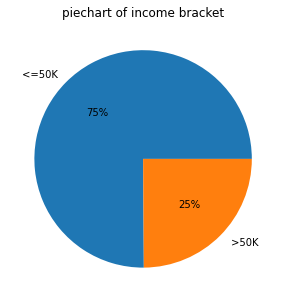

In [16]:
plt.figure(figsize=(15, 5))
plt.pie(df['income_bracket'].value_counts(), labels=df['income_bracket'].unique(), autopct='%.0f%%')
plt.title('piechart of income bracket')

terdapat 75% masyarakat USA yang memiliki pendapatan dibawah `$50,000`. 

#### melihat histogram dari harga

Text(0.5, 1.0, 'education_num')

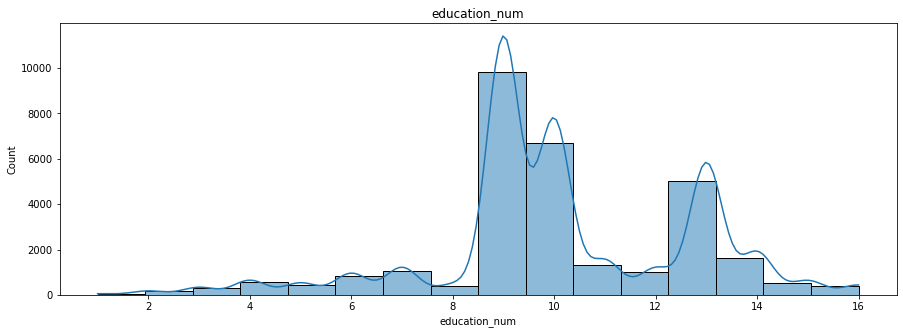

In [17]:
plt.figure(figsize=(15, 5))
sns.histplot(df['education_num'], kde=True, bins=16)
plt.title('education_num')

melihat tingkat edukasi masyarakat US. jadi, frekuensi persebaran tingkat edukasi pada datasheet diatas diketahui bahwa persebaran tertingginya berada dikisaran pendidikan tingkat 9 atau lulusan SMA. rentang jarak yang tercatat dari data tersebut berkisar dari tingkat 1 sampai tingkat 16.

Text(0.5, 1.0, 'Histogram of capital_gain')

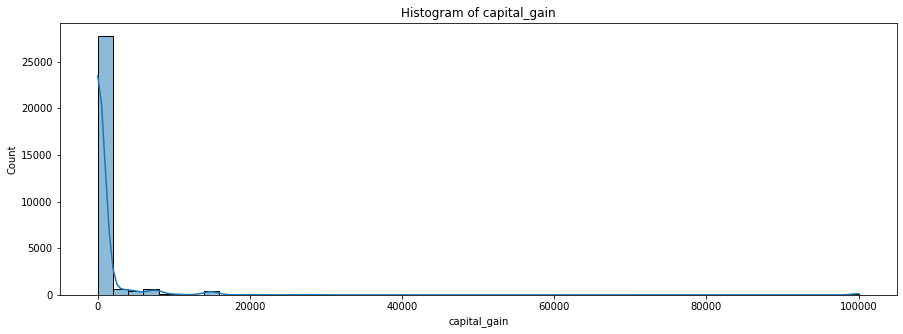

In [18]:
plt.figure(figsize=(15, 5))
sns.histplot(df['capital_gain'], kde=True, bins=50)
plt.title('Histogram of capital_gain')

melihat pendapatan kapital masyarakat US. jadi, frekuensi persebaran pendapatan kapital pada datasheet diatas diketahui bahwa persebaran tertingginya berada dikisaran `$0`. rentang pendapatan kapital yang tercatat dari data tersebut berkisar dari `$0` sampai `$100,000`.

Text(0.5, 1.0, 'Histogram of hours_per_week')

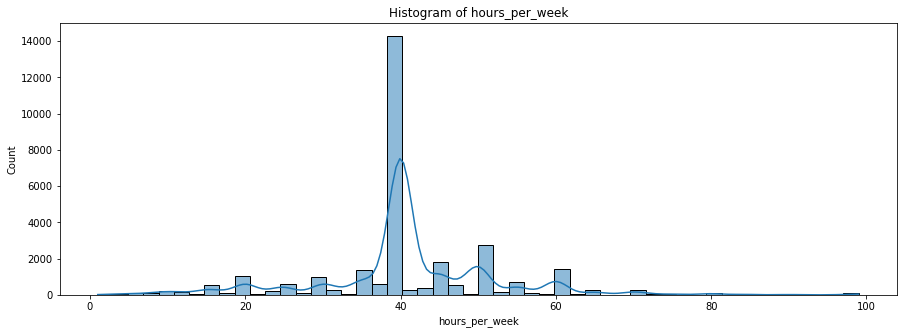

In [19]:
plt.figure(figsize=(15, 5))
sns.histplot(df['hours_per_week'], kde=True, bins=50)
plt.title('Histogram of hours_per_week')

melihat lama kerja per minggu masyarakat US. jadi, frekuensi persebaran lama kerja per minggu pada datasheet diatas diketahui bahwa persebaran tertingginya berada dikisaran 40 jam per minggu. rentang jarak yang tercatat dari data tersebut berkisar dari 1 jam sampai 99 jam.

Text(0.5, 1.0, 'Histogram of age')

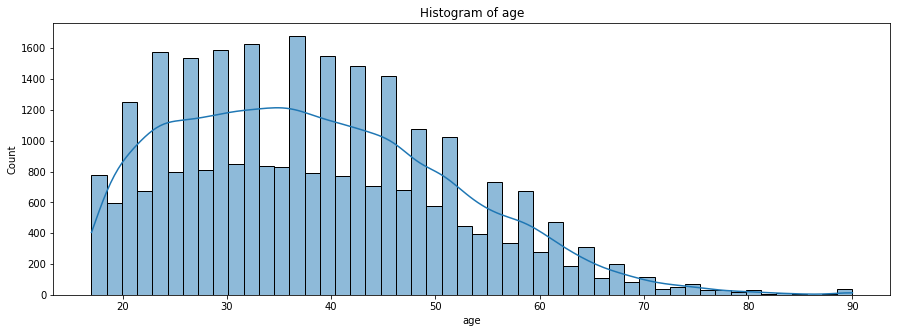

In [20]:
plt.figure(figsize=(15, 5))
sns.histplot(df['age'], kde=True, bins=50)
plt.title('Histogram of age')

melihat persebaran umur masyarakat US. jadi, frekuensi persebaran umur pada datasheet diatas diketahui bahwa persebaran tertingginya berada dikisaran 38 tahun. rentang jarak yang tercatat dari data tersebut berkisar dari 16 tahun sampai 90 tahun.

In [21]:
df['income_bracket'].value_counts()

 <=50K    22654
 >50K      7508
Name: income_bracket, dtype: int64

melihat jumlah masyarakat yang pendapatannya berada dibawah `$50,000` atau tidak. terlihat, masih sebesar 23 ribu jiwa yang memiliki penghasilan dibawah `$50,000` dari datasheet diatas.

# features enginering


## droping data yang `one of a kind`


pada dataset diatas, dicek apakah terdapat data yang sekiranya `one of a kind`, hal ini dilakukan supaya tidak terjadinya value dari data yang tidak ditemukan dalam encoding. bila data `one of a kind` tersebut berada di `test set`, maka nilai nya akan eror sehingga perlu dilakukan penghilangan dahulu.

### melihat macam nilai pada kolom `workclass` 

In [22]:
df['workclass'].value_counts()

 Private             22286
 Self-emp-not-inc     2499
 Local-gov            2067
 State-gov            1279
 Self-emp-inc         1074
 Federal-gov           943
 Without-pay            14
Name: workclass, dtype: int64

dari kolom tersebut, tidak ditemukannya nilai yang dikategorikan `one of a kind`.

### melihat macam nilai pada kolom `education` 

In [23]:
df['education'].value_counts()

 HS-grad         9840
 Some-college    6678
 Bachelors       5044
 Masters         1627
 Assoc-voc       1307
 11th            1048
 Assoc-acdm      1008
 10th             820
 7th-8th          557
 Prof-school      542
 9th              455
 12th             377
 Doctorate        375
 5th-6th          288
 1st-4th          151
 Preschool         45
Name: education, dtype: int64

dari kolom tersebut, tidak ditemukannya nilai yang dikategorikan `one of a kind`.

### melihat macam nilai pada kolom `marital_status` 

In [24]:
df['marital_status'].value_counts()

 Married-civ-spouse       14065
 Never-married             9726
 Divorced                  4214
 Separated                  939
 Widowed                    827
 Married-spouse-absent      370
 Married-AF-spouse           21
Name: marital_status, dtype: int64

dari kolom tersebut, tidak ditemukannya nilai yang dikategorikan `one of a kind`.

### melihat macam nilai pada kolom `occupation` 

In [25]:
df['occupation'].value_counts()

 Prof-specialty       4038
 Craft-repair         4030
 Exec-managerial      3992
 Adm-clerical         3721
 Sales                3584
 Other-service        3212
 Machine-op-inspct    1966
 Transport-moving     1572
 Handlers-cleaners    1350
 Farming-fishing       989
 Tech-support          912
 Protective-serv       644
 Priv-house-serv       143
 Armed-Forces            9
Name: occupation, dtype: int64

dari kolom tersebut, tidak ditemukannya nilai yang dikategorikan `one of a kind`.

### melihat macam nilai pada kolom `relationship` 

In [26]:
df['relationship'].value_counts()

 Husband           12463
 Not-in-family      7726
 Own-child          4466
 Unmarried          3212
 Wife               1406
 Other-relative      889
Name: relationship, dtype: int64

dari kolom tersebut, tidak ditemukannya nilai yang dikategorikan `one of a kind`.

### melihat macam nilai pada kolom `race` 

In [27]:
df['race'].value_counts()

 White                 25933
 Black                  2817
 Asian-Pac-Islander      895
 Amer-Indian-Eskimo      286
 Other                   231
Name: race, dtype: int64

dari kolom tersebut, tidak ditemukannya nilai yang dikategorikan `one of a kind`.

### melihat macam nilai pada kolom `sex` 

In [28]:
df['sex'].value_counts()

 Male      20380
 Female     9782
Name: sex, dtype: int64

dari kolom tersebut, tidak ditemukannya nilai yang dikategorikan `one of a kind`.

### melihat macam nilai pada kolom `native_country` 

In [29]:
df['native_country'].value_counts()

 United-States                 27504
 Mexico                          610
 Philippines                     188
 Germany                         128
 Puerto-Rico                     109
 Canada                          107
 India                           100
 El-Salvador                     100
 Cuba                             92
 England                          86
 Jamaica                          80
 South                            71
 Italy                            68
 China                            68
 Dominican-Republic               67
 Vietnam                          64
 Guatemala                        63
 Japan                            59
 Columbia                         56
 Poland                           56
 Taiwan                           42
 Iran                             42
 Haiti                            42
 Portugal                         34
 Nicaragua                        33
 Peru                             30
 Greece                           29
 

dari kolom tersebut, ditemukannya nilai yang dikategorikan `one of a kind`, yaitu pada value `Holand-Netherlands`. maka sekiranya perlu dilakukan penghilangan data tersebut supaya tidak terjadi eror pada pengetesan model di data tes.

#### melakukan dropping pada value `Holand-Netherlands`

In [30]:
df_drop_1 = df[df["native_country"].str.contains("Holand-Netherlands") == False]

dilakukan pengecekan kembali pada kolom `native_country`

In [31]:
df_drop_1['native_country'].value_counts()

 United-States                 27504
 Mexico                          610
 Philippines                     188
 Germany                         128
 Puerto-Rico                     109
 Canada                          107
 El-Salvador                     100
 India                           100
 Cuba                             92
 England                          86
 Jamaica                          80
 South                            71
 Italy                            68
 China                            68
 Dominican-Republic               67
 Vietnam                          64
 Guatemala                        63
 Japan                            59
 Columbia                         56
 Poland                           56
 Iran                             42
 Haiti                            42
 Taiwan                           42
 Portugal                         34
 Nicaragua                        33
 Peru                             30
 Greece                           29
 

## menghapus kolom yang tidak terpakai 

hal ini bertujuan untuk menghapus kolom yang tidak terpakai. diketahui dalam data set diatas terdapat 2 kolom yang sama, yaitu `education` dan `education_num`. kolom `education` yang merupakan gelar yang didapat pada `education_num`. sehingga, untuk membuat model cukup digunakan satu saja. karena kolom `education_num` sudah bisa menerangkan apa isi dari kolom `education`.

melakukan droping pada kolom `education`

In [32]:
df_drop_2 = df_drop_1.drop(['education'], axis= 1)

melihat kembali apa isi dataset yang akan kita gunakan.

In [33]:
df_drop_2.head()

,age,workclass,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
0,39,Private,5,Married-civ-spouse,Other-service,Wife,Black,Female,3411,0,34,United-States,<=50K
1,77,Private,5,Married-civ-spouse,Priv-house-serv,Wife,Black,Female,0,0,10,United-States,<=50K
2,38,Private,5,Married-civ-spouse,Other-service,Wife,Black,Female,0,0,24,Haiti,<=50K
3,28,Private,5,Married-civ-spouse,Protective-serv,Wife,Black,Female,0,0,40,United-States,<=50K
4,37,Private,5,Married-civ-spouse,Machine-op-inspct,Wife,Black,Female,0,0,48,United-States,<=50K


## split data train dan test

In [34]:
train, test = train_test_split(df_drop_2, test_size=0.2, random_state=2)

print('Train Size : ', train.shape)
print('Test Size  : ', test.shape)
train

Train Size :  (24128, 13)
Test Size  :  (6033, 13)


,age,workclass,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
12015,28,Private,9,Never-married,Adm-clerical,Not-in-family,White,Male,0,0,40,United-States,<=50K
2531,18,Private,8,Never-married,Adm-clerical,Own-child,White,Female,0,0,20,United-States,<=50K
10040,42,Private,9,Divorced,Craft-repair,Unmarried,White,Male,0,0,45,United-States,<=50K
1285,38,Private,7,Married-civ-spouse,Adm-clerical,Wife,White,Female,0,0,32,United-States,<=50K
1943,23,Self-emp-not-inc,7,Never-married,Craft-repair,Own-child,White,Male,0,0,50,Mexico,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18898,40,Self-emp-not-inc,13,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,50,United-States,<=50K
11798,31,Private,9,Separated,Other-service,Not-in-family,White,Male,0,0,40,United-States,<=50K
6637,25,Private,9,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,45,United-States,<=50K
2575,22,Private,8,Married-spouse-absent,Other-service,Unmarried,Black,Female,0,0,50,United-States,<=50K


## melihat apa ada missing value pada data latihan

memastikan tidak ada missing value pada data latihan

In [35]:
train.isnull().mean()

age               0.0
workclass         0.0
education_num     0.0
marital_status    0.0
occupation        0.0
relationship      0.0
race              0.0
sex               0.0
capital_gain      0.0
capital_loss      0.0
hours_per_week    0.0
native_country    0.0
income_bracket    0.0
dtype: float64

dari hasil yang diberikan diatas, tidak ditemukan data yang hilang pada data latihan.

In [36]:
train_clean = train.dropna()

## outlier data latihan

melakukan aksi yang perlu dilakukan bila terdapat data yang jelek persebarannya sehingga data yang digunakan untuk latihan baik persebarannya.

### cek outlier

mengecek akan adanya outlier pada data latihan di kolom `education_num` yang kita punya.

Text(0.5, 1.0, 'Boxplot')

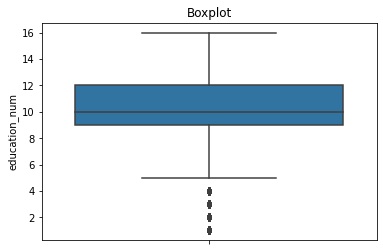

In [37]:
sns.boxplot(y=train['education_num'])
plt.title('Boxplot')

melihat `boxplot` dari kolom `education_num`. Boxplot atau Box-Plot merupakan visualisasi data berbentuk box (kotak berbentuk bujur sangkar). Boxplot dapat digunakan untuk menunjukkan perbedaan antara populasi tanpa menggunakan asumsi distribusi statistik yang mendasarinya. dari tabel diatas, diketahui terdapat beberapa data dari kolom `education_num` yang bertepatan dibawah nilai yang telah ditentukan.

In [38]:
train['education_num'].skew()

-0.31442799070661154

melihat kemiringan dari kolom `education_num`, `skewness` merupakan ukuran ketidaksimetrisan dalam penyebaran data. jadi, dapat diartikan `skewness` yang bernilai positif lebih dari 0 akan membuat ekor dari persebaran datanya condong lebih panjang kekanan serta bila bernilai negatif atau kurang dari 0 maka akan membuat ekor dari persebaran datanya condong lebih panjang ke kiri. bila diartikan dalam tabel berikut, maka kesimpulan yang didapatkan ialah "persebaran data `education_num` pada datasheet yang diatas memiliki catatan bahwa terdapat masyarakat yang memiliki `education_num` tingkat pendidikan dibawah `outlier` yang telah ditentukan.

mengecek akan adanya outlier pada data latihan di kolom `age` yang kita punya.

Text(0.5, 1.0, 'Boxplot')

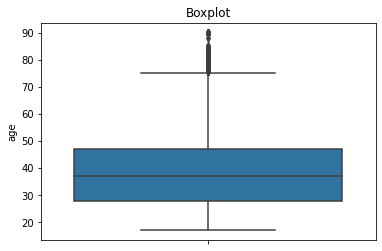

In [39]:
sns.boxplot(y=train['age'])
plt.title('Boxplot')

melihat `boxplot` dari kolom `age`. Boxplot atau Box-Plot merupakan visualisasi data berbentuk box (kotak berbentuk bujur sangkar). Boxplot dapat digunakan untuk menunjukkan perbedaan antara populasi tanpa menggunakan asumsi distribusi statistik yang mendasarinya. dari tabel diatas, diketahui terdapat beberapa data dari kolom `age` yang bertepatan diatas nilai yang telah ditentukan.

dilakukan pengecekan skewness pada dataset diatas. hal ini

In [40]:
train['age'].skew()

0.5287737518199205

melihat kemiringan dari kolom `age`, `skewness` merupakan ukuran ketidaksimetrisan dalam penyebaran data. jadi, dapat diartikan `skewness` yang bernilai positif lebih dari 0 akan membuat ekor dari persebaran datanya condong lebih panjang kekanan serta bila bernilai negatif atau kurang dari 0 maka akan membuat ekor dari persebaran datanya condong lebih panjang ke kiri. bila diartikan dalam tabel berikut, maka kesimpulan yang didapatkan ialah "persebaran data `age` pada datasheet yang diatas memiliki catatan bahwa terdapat masyarakat yang memiliki `age` tingkat usia diatas `outlier` yang telah ditentukan.

mengecek akan adanya outlier pada data latihan di kolom `capital_gain` yang kita punya.

Text(0.5, 1.0, 'Boxplot')

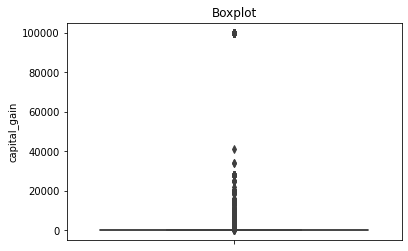

In [41]:
sns.boxplot(y=train['capital_gain'])
plt.title('Boxplot')

melihat `boxplot` dari kolom `capital_gain`. Boxplot atau Box-Plot merupakan visualisasi data berbentuk box (kotak berbentuk bujur sangkar). Boxplot dapat digunakan untuk menunjukkan perbedaan antara populasi tanpa menggunakan asumsi distribusi statistik yang mendasarinya. dari tabel diatas, diketahui terdapat beberapa data dari kolom `capital_gain` yang bertepatan diatas nilai yang telah ditentukan.

In [42]:
train['capital_gain'].skew()

11.975709547412052

melihat kemiringan dari kolom `capital_gain`, `skewness` merupakan ukuran ketidaksimetrisan dalam penyebaran data. jadi, dapat diartikan `skewness` yang bernilai positif lebih dari 0 akan membuat ekor dari persebaran datanya condong lebih panjang kekanan serta bila bernilai negatif atau kurang dari 0 maka akan membuat ekor dari persebaran datanya condong lebih panjang ke kiri. bila diartikan dalam tabel berikut, maka kesimpulan yang didapatkan ialah "persebaran data `capital_gain` pada datasheet yang diatas memiliki catatan bahwa terdapat masyarakat yang memiliki `capital_gain` tingkat pendapatan capital diatas `outlier` yang telah ditentukan.

mengecek akan adanya outlier pada data latihan di kolom `capital_loss` yang kita punya.

Text(0.5, 1.0, 'Boxplot')

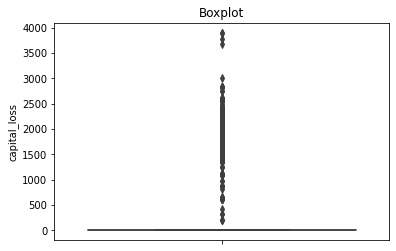

In [43]:
sns.boxplot(y=train['capital_loss'])
plt.title('Boxplot')

melihat `boxplot` dari kolom `capital_loss`. Boxplot atau Box-Plot merupakan visualisasi data berbentuk box (kotak berbentuk bujur sangkar). Boxplot dapat digunakan untuk menunjukkan perbedaan antara populasi tanpa menggunakan asumsi distribusi statistik yang mendasarinya. dari tabel diatas, diketahui terdapat beberapa data dari kolom `capital_loss` yang bertepatan diatas nilai yang telah ditentukan.

In [44]:
train['capital_loss'].skew()

4.496040764712553

melihat kemiringan dari kolom `capital_loss`, `skewness` merupakan ukuran ketidaksimetrisan dalam penyebaran data. jadi, dapat diartikan `skewness` yang bernilai positif lebih dari 0 akan membuat ekor dari persebaran datanya condong lebih panjang kekanan serta bila bernilai negatif atau kurang dari 0 maka akan membuat ekor dari persebaran datanya condong lebih panjang ke kiri. bila diartikan dalam tabel berikut, maka kesimpulan yang didapatkan ialah "persebaran data `capital_loss` pada datasheet yang diatas memiliki catatan bahwa terdapat masyarakat yang memiliki `capital_loss` tingkat kerugian capital diatas `outlier` yang telah ditentukan.

mengecek akan adanya outlier pada data latihan di kolom `hours_per_week` yang kita punya.

Text(0.5, 1.0, 'Boxplot')

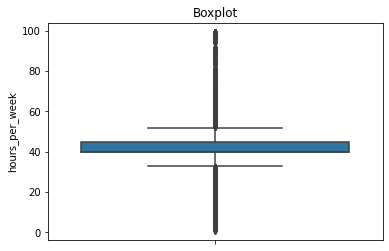

In [45]:
sns.boxplot(y=train['hours_per_week'])
plt.title('Boxplot')

melihat `boxplot` dari kolom `hours_per_week`. Boxplot atau Box-Plot merupakan visualisasi data berbentuk box (kotak berbentuk bujur sangkar). Boxplot dapat digunakan untuk menunjukkan perbedaan antara populasi tanpa menggunakan asumsi distribusi statistik yang mendasarinya. dari tabel diatas, diketahui terdapat beberapa data dari kolom `hours_per_week` yang bertepatan diatas maupun dibawah nilai yang telah ditentukan.

In [46]:
train['hours_per_week'].skew()

0.32596207957100176

melihat kemiringan dari kolom `hours_per_week`, `skewness` merupakan ukuran ketidaksimetrisan dalam penyebaran data. jadi, dapat diartikan `skewness` yang bernilai positif lebih dari 0 akan membuat ekor dari persebaran datanya condong lebih panjang kekanan serta bila bernilai negatif atau kurang dari 0 maka akan membuat ekor dari persebaran datanya condong lebih panjang ke kiri. bila diartikan dalam tabel berikut, maka kesimpulan yang didapatkan ialah "persebaran data `hours_per_week` pada datasheet yang diatas memiliki catatan bahwa terdapat masyarakat yang memiliki `hours_per_week` tingkat jam kerja tiap minggu diatas maupun dibawah `outlier` yang telah ditentukan.

### cleaning

dikarenakan dataset yang kita milik terdapat beberapa natural outlier dan data yang aneh, maka perlu kita seleksi. data yang memiliki `natural outlier` diantaranya ialah `capital_gain` dan `capital_loss`. hal ini dikarenakan menurut pemahaman saya, `capital_gain` dan `capital_loss` merupakan harta simpanan yang memang tidak disebabkan karena adanya eror saat proses sampling data yang tidak seimbang. sehingga `capital_gain` dan `capital_loss` tidak akan saya coba hilangkan. sedangkan untuk `age`, `education_num` dan `hours_per_week` akan saya coba *treatment* karena saya berpendapat bahwa ini adalah kesalahan sampling yang tidak merata.

Menetapkan IQR pada kolom `education_num` dan memberikan *lower_boundary* dan *upper_boundary* pada kolom tersebut.

In [47]:
IQR = train['education_num'].quantile(0.75) - train['education_num'].quantile(0.25)

lower_boundary = train['education_num'].quantile(0.25) - (IQR * 1.5)
upper_boundary = train['education_num'].quantile(0.75) + (IQR * 1.5)

print(lower_boundary)
print(upper_boundary)

4.5
16.5


mencari data mana saja yang nilai `education_num` berada diatas maupun dibawah outlier.

In [48]:
outliers_distance = np.where(train['education_num'] > upper_boundary, True,
                    np.where(train['education_num'] < lower_boundary, True, False))
outliers_distance

array([False, False, False, ..., False, False, False])

dilakukan pemotongan data yang melebihi dan kurang dari outlier `education_num`

In [49]:
train_trimmed = train.loc[~(outliers_distance)]
train_trimmed

,age,workclass,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
12015,28,Private,9,Never-married,Adm-clerical,Not-in-family,White,Male,0,0,40,United-States,<=50K
2531,18,Private,8,Never-married,Adm-clerical,Own-child,White,Female,0,0,20,United-States,<=50K
10040,42,Private,9,Divorced,Craft-repair,Unmarried,White,Male,0,0,45,United-States,<=50K
1285,38,Private,7,Married-civ-spouse,Adm-clerical,Wife,White,Female,0,0,32,United-States,<=50K
1943,23,Self-emp-not-inc,7,Never-married,Craft-repair,Own-child,White,Male,0,0,50,Mexico,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18898,40,Self-emp-not-inc,13,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,50,United-States,<=50K
11798,31,Private,9,Separated,Other-service,Not-in-family,White,Male,0,0,40,United-States,<=50K
6637,25,Private,9,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,45,United-States,<=50K
2575,22,Private,8,Married-spouse-absent,Other-service,Unmarried,Black,Female,0,0,50,United-States,<=50K


Menetapkan IQR pada kolom `age` dan memberikan *lower_boundary* dan *upper_boundary* pada kolom tersebut.

In [50]:
IQR_2 = train_trimmed['age'].quantile(0.75) - train_trimmed['age'].quantile(0.25)

lower_boundary_2 = train_trimmed['age'].quantile(0.25) - (IQR * 3)
upper_boundary_2 = train_trimmed['age'].quantile(0.75) + (IQR * 3)

print(lower_boundary_2)
print(upper_boundary_2)

19
56


mencari data mana saja yang nilai `age` berada diatas maupun dibawah outlier.

In [51]:
outliers_distance_2 = np.where(train_trimmed['age'] > upper_boundary_2, True,
                    np.where(train_trimmed['age'] < lower_boundary_2, True, False))
outliers_distance_2

array([False,  True, False, ..., False, False, False])

dilakukan pemotongan data yang melebihi dan kurang dari outlier `age`

In [52]:
train_trimmed_2 = train_trimmed.loc[~(outliers_distance_2)]
train_trimmed_2

,age,workclass,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
12015,28,Private,9,Never-married,Adm-clerical,Not-in-family,White,Male,0,0,40,United-States,<=50K
10040,42,Private,9,Divorced,Craft-repair,Unmarried,White,Male,0,0,45,United-States,<=50K
1285,38,Private,7,Married-civ-spouse,Adm-clerical,Wife,White,Female,0,0,32,United-States,<=50K
1943,23,Self-emp-not-inc,7,Never-married,Craft-repair,Own-child,White,Male,0,0,50,Mexico,<=50K
27679,32,Local-gov,10,Never-married,Adm-clerical,Unmarried,Black,Female,0,0,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18898,40,Self-emp-not-inc,13,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,50,United-States,<=50K
11798,31,Private,9,Separated,Other-service,Not-in-family,White,Male,0,0,40,United-States,<=50K
6637,25,Private,9,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,45,United-States,<=50K
2575,22,Private,8,Married-spouse-absent,Other-service,Unmarried,Black,Female,0,0,50,United-States,<=50K


Menetapkan IQR pada kolom `hours_per_week` dan memberikan *lower_boundary* dan *upper_boundary* pada kolom tersebut.

In [53]:
IQR_3 = train_trimmed_2['hours_per_week'].quantile(0.75) - train_trimmed_2['hours_per_week'].quantile(0.25)

lower_boundary_3 = train_trimmed_2['hours_per_week'].quantile(0.25) - (IQR * 1.5)
upper_boundary_3 = train_trimmed_2['hours_per_week'].quantile(0.75) + (IQR * 1.5)

print(lower_boundary_3)
print(upper_boundary_3)

35.5
49.5


mencari data mana saja yang nilai `hours_per_week` berada diatas maupun dibawah outlier.

In [54]:
outliers_distance_3 = np.where(train_trimmed_2['hours_per_week'] > upper_boundary_3, True,
                    np.where(train_trimmed_2['hours_per_week'] < lower_boundary_3, True, False))
outliers_distance_3

array([False, False,  True, ..., False,  True, False])

dilakukan pemotongan data yang melebihi dan kurang dari outlier `hours_per_week`

In [55]:
train_trimmed_3 = train_trimmed_2.loc[~(outliers_distance_3)]
train_trimmed_3

,age,workclass,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
12015,28,Private,9,Never-married,Adm-clerical,Not-in-family,White,Male,0,0,40,United-States,<=50K
10040,42,Private,9,Divorced,Craft-repair,Unmarried,White,Male,0,0,45,United-States,<=50K
27679,32,Local-gov,10,Never-married,Adm-clerical,Unmarried,Black,Female,0,0,40,United-States,<=50K
9604,35,Private,9,Widowed,Other-service,Unmarried,Black,Male,0,0,40,United-States,<=50K
6017,37,Private,9,Married-civ-spouse,Other-service,Husband,White,Male,0,0,40,Guatemala,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...
433,23,Private,5,Never-married,Handlers-cleaners,Other-relative,White,Male,0,0,39,Mexico,<=50K
14696,46,Private,14,Widowed,Prof-specialty,Not-in-family,White,Female,0,0,44,United-States,<=50K
11798,31,Private,9,Separated,Other-service,Not-in-family,White,Male,0,0,40,United-States,<=50K
6637,25,Private,9,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,45,United-States,<=50K


setelah dilakukan *treatment* pada data yang kita punya, selanjutnya dilakukan pembagian antara input dan output.

## split `X` dan `y`


disini, saya akan membuat nilai dari `income_bracket` sebagai output dan sisanya merupakan input yang kita miliki.

In [56]:
X_train = train_trimmed_3.drop(['income_bracket'], axis=1)
X_test = test.drop(['income_bracket'], axis=1)

y_train = train_trimmed_3['income_bracket']
y_test = test['income_bracket']
y_test

24154      >50K
2999      <=50K
8943      <=50K
22646     <=50K
9462      <=50K
          ...  
29293     <=50K
24936     <=50K
504        >50K
25538     <=50K
10883     <=50K
Name: income_bracket, Length: 6033, dtype: object

## memisahkan data numerik dan data kategori

disini saya memisahkan bagian mana saja yang termasuk dalam numerik dan bagian mana saja yang termasuk dalam kategorikal. hal ini saya lakukan untuk dilakukannya treatment yang berbeda antara data kategorikal dan data numerikal.

In [57]:
X_num = ['age', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
X_cat = ['workclass','marital_status','occupation','relationship','race','sex','native_country']

In [58]:
X_train_num = train_trimmed_3[['age', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']]
X_test_num = test[['age', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']]

X_train_cat = train_trimmed_3[['workclass','marital_status','occupation','relationship','race','sex','native_country']]
X_test_cat = test[['workclass','marital_status','occupation','relationship','race','sex','native_country']]


saya memasukkan kolom `'age', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week'` dalam kategori data numerikal dan kolom `'workclass','marital_status','occupation','relationship','race','sex','native_country'` sebagai data kategorikal. kemudian keduanya dimasukkan kedalam data latihan dan data tes.

## encoding

melakukan `encoding` pada `data kategori` guna dapat dihitung dengan `maching learning`

In [59]:
encoder = OneHotEncoder()

encoder.fit(X_train_cat)

X_train_cat_encoded = encoder.transform(X_train_cat).toarray()
X_test_cat_encoded = encoder.transform(X_test_cat).toarray()

X_test_cat_encoded

array([[0., 0., 1., ..., 1., 0., 0.],
       [0., 0., 1., ..., 1., 0., 0.],
       [0., 0., 1., ..., 1., 0., 0.],
       ...,
       [0., 0., 1., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 1., 0., 0.]])

saya menggunakan metode `onehotencoder` dikarenakan tidak adanya ranking pada setiap kolom kategorinya.

## scalling

saya melakukan `scalling` pada `data numerikal`, sehingga data yang didapat memberikan efek yang sama pada `output` yang akan dihasilkan nantinya. disini saya `scalling` dengan menggunakan metode `min max scaller` karena persebaran data-nya yang agak ekstrim yang dilihat pada nilai `skewness` diatas. bila persebaran datanya normal, maka perlu dilakukan `scalling` dengan metode `Standard Scaler`.

In [60]:
scaler = MinMaxScaler()
scaler.fit(X_train_num)

X_train_num_scaled = scaler.transform(X_train_num)
X_test_num_scaled = scaler.transform(X_test_num)
X_test_num_scaled

array([[ 0.91891892,  0.45454545,  0.1502415 ,  0.        ,  0.30769231],
       [ 0.97297297, -0.18181818,  0.        ,  0.        , -0.84615385],
       [ 0.02702703,  0.36363636,  0.        ,  0.        ,  0.30769231],
       ...,
       [ 0.89189189,  0.09090909,  0.        ,  0.48384615,  0.84615385],
       [ 1.35135135,  0.45454545,  0.        ,  0.        , -1.53846154],
       [ 0.56756757,  0.36363636,  0.        ,  0.        , -0.46153846]])

saya melakukan `scalling` data pada `data latihan `saja agar hasil output dari `data tes` tidak bocor.

## concate

menggabungkan semua `data kategori` dan `data numerikal` pada `data latihan` dan `data tes`

In [61]:
X_train_final = np.concatenate([X_train_num_scaled, X_train_cat_encoded], axis=1)
X_test_final = np.concatenate([X_test_num_scaled, X_test_cat_encoded], axis=1)
X_train_final

array([[0.24324324, 0.36363636, 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.62162162, 0.36363636, 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.35135135, 0.45454545, 0.        , ..., 1.        , 0.        ,
        0.        ],
       ...,
       [0.32432432, 0.36363636, 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.16216216, 0.36363636, 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.43243243, 0.45454545, 0.        , ..., 1.        , 0.        ,
        0.        ]])

# model definition

dengan mengetahui bahwa kita akan mencoba untuk menentukan data yang kita miliki termasuk kategori apa. maka kita perlu memberikan model maching learning yang dapat menentukan target yang dimiliki itu di kategori apa. kali ini saya menggunakan 2 buah model yaitu `regresi logistik` dan `SVM` jenis `SVC`. pada model SVM kali ini saya mencoba memasukkan 3 jenis `C` yang berbeda yaitu `0.1`, `1`, dan `10`.

In [62]:
model_log_reg = LogisticRegression(solver="lbfgs")
svc_linear_1 = SVC(kernel='linear', gamma="auto", C= 0.1)
svc_linear_2 = SVC(kernel='linear', gamma="auto", C= 1)
svc_linear_3 = SVC(kernel='linear', gamma="auto", C= 10)

# model training

saya coba melakukan pelatihan pada komputer dengan data yang telah saya sediakan.

## logreg


saya coba melakukan pelatihan pada komputer dengan data yang telah saya sediakan dengan menggunakan `regresi logistik`

---



In [63]:
model_log_reg.fit(X_train_final, y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

## SVM

saya coba melakukan pelatihan pada komputer dengan data yang telah saya sediakan dengan menggunakan `SVM`


### kernel='linear', gamma="auto", C= 0.1

saya mencoba memasukkan data dengan hyperparameter antara lain `kernel='linear', gamma="auto", C= 0.1`




In [64]:
svc_linear_1.fit(X_train_final, y_train)# Make prediction

SVC(C=0.1, gamma='auto', kernel='linear')

### kernel='linear', gamma="auto", C= 1

saya mencoba memasukkan data dengan hyperparameter antara lain `kernel='linear', gamma="auto", C= 1`

In [65]:
svc_linear_2.fit(X_train_final, y_train)# Make prediction

SVC(C=1, gamma='auto', kernel='linear')

### kernel='linear', gamma="auto", C= 10

saya mencoba memasukkan data dengan hyperparameter antara lain `kernel='linear', gamma="auto", C= 10`

In [66]:
svc_linear_3.fit(X_train_final, y_train)# Make prediction

SVC(C=10, gamma='auto', kernel='linear')

# model Evaluation


saya mencoba mengevaluasi model dengan melihat hasil yang didapatkan pada tes yang dilakukan.

## log_reg

In [67]:
y_pred_log_reg = model_log_reg.predict(X_test_final)

print("Evaluation: logistik regresi")
print('Training score: {:.4f}'.format(model_log_reg.score(X_train_final, y_train)))
print('Test score: {:.4f}'.format(model_log_reg.score(X_test_final, y_test)))

print(classification_report(y_test,y_pred_log_reg))

Evaluation: logistik regresi
Training score: 0.8447
Test score: 0.8354
              precision    recall  f1-score   support

       <=50K       0.89      0.89      0.89      4527
        >50K       0.67      0.68      0.67      1506

    accuracy                           0.84      6033
   macro avg       0.78      0.78      0.78      6033
weighted avg       0.84      0.84      0.84      6033



dengan model logistik regresi, didapatkan bahwa nilai akurasi di kategori `<= $50,000` bernilai 0,89 dan pada kategori `> $50,000` bernilai 0,67 sehingga total akurari yang didapatkan berada di nilai 0,84. nilai akurasi adalah persentase jumlah data yang diprediksi secara benar terhadap jumlah keseluruhan data. sehingga, model saya telah mempredisi dengan benar terhadap 84% data yang diberikan. hasil model yang diperoleh dalam data latihan dan data tes dilihat masih memiliki nilai yang menyerupai, sehingga dapat dikatakan bahwa model tersebut dikategorikan `goodfit`

## SVM


In [68]:
y_pred_linear = svc_linear_1.predict(X_test_final)

print("Evaluation: Linear kernel, C = 0,1")
print('Training score: {:.4f}'.format(svc_linear_1.score(X_train_final, y_train)))
print('Test score: {:.4f}'.format(svc_linear_1.score(X_test_final, y_test)))

print(classification_report(y_test,y_pred_linear))

Evaluation: Linear kernel, C = 0,1
Training score: 0.8350
Test score: 0.8296
              precision    recall  f1-score   support

       <=50K       0.88      0.89      0.89      4527
        >50K       0.67      0.64      0.65      1506

    accuracy                           0.83      6033
   macro avg       0.77      0.77      0.77      6033
weighted avg       0.83      0.83      0.83      6033



dengan model SVM ke 1, didapatkan bahwa nilai akurasi di kategori `<= $50,000` bernilai 0,89 dan pada kategori `> $50,000` bernilai 0,65 sehingga total akurari yang didapatkan berada di nilai 0,83 . nilai akurasi adalah persentase jumlah data yang diprediksi secara benar terhadap jumlah keseluruhan data. sehingga, model saya telah mempredisi dengan benar terhadap 84% data yang diberikan. hasil model yang diperoleh dalam data latihan dan data tes dilihat masih memiliki nilai yang menyerupai, sehingga dapat dikatakan bahwa model tersebut dikategorikan `goodfit`

In [69]:
y_pred_linear_2 = svc_linear_2.predict(X_test_final)# Evaluate our model

print("Evaluation: Linear kernel, C = 1")
print('Training score: {:.4f}'.format(svc_linear_2.score(X_train_final, y_train)))
print('Test score: {:.4f}'.format(svc_linear_2.score(X_test_final, y_test)))

print(classification_report(y_test,y_pred_linear_2))

Evaluation: Linear kernel, C = 1
Training score: 0.8473
Test score: 0.8392
              precision    recall  f1-score   support

       <=50K       0.89      0.90      0.89      4527
        >50K       0.68      0.67      0.68      1506

    accuracy                           0.84      6033
   macro avg       0.79      0.78      0.78      6033
weighted avg       0.84      0.84      0.84      6033



dengan model SVM ke 2, didapatkan bahwa nilai akurasi di kategori `<= $50,000` bernilai 0,89 dan pada kategori `> $50,000` bernilai 0,68 sehingga total nilai akurasi berada di nilai 0,84. nilai akurasi adalah persentase jumlah data yang diprediksi secara benar terhadap jumlah keseluruhan data. sehingga, model saya telah mempredisi dengan benar terhadap 85% data yang diberikan.  hasil model yang diperoleh dalam data latihan dan data tes dilihat masih memiliki nilai yang menyerupai, sehingga dapat dikatakan bahwa model tersebut dikategorikan `goodfit`

In [70]:
y_pred_linear_3 = svc_linear_3.predict(X_test_final)# Evaluate our model

print("Evaluation: Linear kernel, C = 10")
print('Training score: {:.4f}'.format(svc_linear_3.score(X_train_final, y_train)))
print('Test score: {:.4f}'.format(svc_linear_3.score(X_test_final, y_test)))

print(classification_report(y_test,y_pred_linear_3))

Evaluation: Linear kernel, C = 10
Training score: 0.8503
Test score: 0.8450
              precision    recall  f1-score   support

       <=50K       0.90      0.90      0.90      4527
        >50K       0.69      0.69      0.69      1506

    accuracy                           0.85      6033
   macro avg       0.79      0.79      0.79      6033
weighted avg       0.84      0.85      0.84      6033



dengan model SVM ke 3, didapatkan bahwa nilai akurasi di kategori `<= $50,000` bernilai 0,90 dan pada kategori `> $50,000` bernilai 0,69 sehingga total nilai akurasi berada di nilai 0,85. nilai akurasi adalah persentase jumlah data yang diprediksi secara benar terhadap jumlah keseluruhan data. sehingga, model saya telah mempredisi dengan benar terhadap 85% data yang diberikan.  hasil model yang diperoleh dalam data latihan dan data tes dilihat masih memiliki nilai yang menyerupai, sehingga dapat dikatakan bahwa model tersebut dikategorikan `goodfit`

# model saving


menyimpan data yang telah diproses oleh `machine learning`

In [71]:
with open('log_reg.pkl', 'wb') as file_1:
  pickle.dump(model_log_reg, file_1)

with open('SVC.pkl', 'wb') as file_2:
  pickle.dump(svc_linear_3, file_2)

with open('model_scaler.pkl', 'wb') as file_3:
  pickle.dump(scaler, file_3)

with open('model_encoder.pkl', 'wb') as file_4:
  pickle.dump(encoder, file_4)

with open('list_num_cols.txt', 'w') as file_5:
  json.dump(X_num, file_5)

with open('list_cat_cols.txt','w') as file_6:
  json.dump(X_cat, file_6)

# conceptual question


### Apakah yang dimaksud dengan coeficient pada logistic regression?



simpelnya ialah koefisien pada logistik regresi itu bernilai pangkat. ketika ada suatu nilai memliki nilai koefisien sebesar 0,5. nilai kemungkinan terjadi akan menjadi 10^0,5 yaitu sebesar 3,16. sehingga bila di artikan ialah nilai a mempunyai 3,16 kali lipat dari yang bukan nilai a.

rumus koefisien losigtik regresi:

`logit(p) = a+ bX₁`

dimana b adalah nilai dari koefisiennya. 

### Apakah yang dimaksud dengan Support Vector pada SVM?

support vector dalam svm adalah data point pada dataset yang berada paling dekat dengan hyperplane(garis, bidang atau dimensi lainnya) yang dipilih untuk memisahkan satu kelas dengan kelas lainnya. posisi support vector ini dinilai sangat penting karena berhubungan dengan pengelompokkan data tersebut.

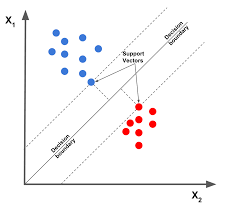

### Apakah fungsi parameter kernel pada SVM? Jelaskan salah satu kernel yang kalian pahami!

kernel merupakan sebuah fungsi untuk menentukan data yang diinput dengan model tertentu sehingga hasilnya menjadi lebih baik. pemilihan model kernel dilakukan ketika semua cara kita coba pada 2 dimensi tetapi hasil data yang dihasilkan tidak optimal, maka oleh karena itu pemilihan kernel salah satunya menambahkan dimensi pada model yang kita gunakan untuk mendapatkan hasil yang diinginkan.



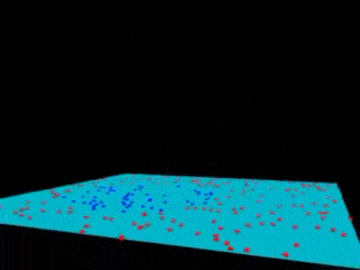

salah satu contoh kernel ialah polynomial kernel. dapat disaksikan pada gif diatas, ternyata data yang didapatkan dimasukkan ke dimensi yang lebih tinggi, sehingga bentuk modelnya menjadi semakin baik. ketika dimasukkan kedalam 2 dimensi, terdapat keanehan pada semua hasilnya sehingga kita perlu menaikkan 1 dimensi lagi untuk mendapatkan hasil yang baik.

# kesimpulan

dengan uji yang telah dilakukan, ternyata terdapat beberapa data yang bersifat nilai data kategori yang bersifat `one of a kind`, serta data yang memiliki `outlier`. dengan literasi yang menunjukkan bahwa banyak penduduk US yang memiliki pendapatan dibawah `$50,000` sebesar 36,1%, namun pada data yang saya dapat kali ini pendapatan dibawah `$50,000` sebesar 75%. dilakukan pengerjaan model untuk menentukan kategori `income_bracket` dengan `regresi logistik` dan `SVM`. dengan model `logistik regresi` yang saya gunakan mempunyai total nilai `akurasi` sebesar 84% dan untuk model SVM terbaik didapatkan oleh SVM dengan hyperparameter `kernel='linear', gamma="auto", C= 10` dengan total nilai akurasi 85%. untuk memperbaiki nilai akurasi pada model, dapat dilakukan perbaikan pada data yang diperoleh agar datanya lebih seimbang, atau dilakukan `undersampling` pada data diatas.